## kaggle:https://www.kaggle.com/code/czy111/ae-mnist

In [1]:
!python --version

Python 3.6.6 :: Anaconda, Inc.


In [1]:
!git clone https://github.com/davidADSP/GDL_code.git

Cloning into 'GDL_code'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 394 (delta 0), reused 1 (delta 0), pack-reused 391
Receiving objects: 100% (394/394), 22.13 MiB | 11.62 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [3]:
!git pull

fatal: Not a git repository (or any parent up to mount point /kaggle/working)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
cd /kaggle/working/GDL_code

/kaggle/working/GDL_code


In [ ]:
pip install -r requirements.txt

In [3]:
!mkdir vae

In [4]:
cd vae

/kaggle/working/GDL_code/vae


## AutoEncoder生成手写数字(tensorflow)

In [6]:
%%writefile callbacks.py 
from keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os

#### CALLBACKS
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)

Writing callbacks.py


In [7]:
%%writefile AE.py
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

from callbacks import CustomCallback, step_decay_schedule

import numpy as np
import json
import os
import pickle


class Autoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout = False
        ):

        self.name = 'autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):

        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        encoder_output= Dense(self.z_dim, name='encoder_output')(x)

        self.encoder = Model(encoder_input, encoder_output)


        ### THE DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                x = LeakyReLU()(x)
                
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL AUTOENCODER
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)


    def compile(self, learning_rate):
        self.learning_rate = learning_rate

        optimizer = Adam(lr=learning_rate)

        def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

        self.model.compile(optimizer=optimizer, loss = r_loss)

    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)

        


    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    
    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint2, custom_callback, lr_sched]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)




Writing AE.py


In [8]:
%%writefile loaders.py
import pickle
import os

from keras.datasets import mnist, cifar100,cifar10
from keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array

import pandas as pd

import numpy as np
from os import walk, getcwd
import h5py

import scipy
from glob import glob

from keras.applications import vgg19
from keras import backend as K
from keras.utils import to_categorical

import pdb


class ImageLabelLoader():
    def __init__(self, image_folder, target_size):
        self.image_folder = image_folder
        self.target_size = target_size

    def build(self, att, batch_size, label = None):

        data_gen = ImageDataGenerator(rescale=1./255)
        if label:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , y_col=label
                , target_size=self.target_size 
                , class_mode='other'
                , batch_size=batch_size
                , shuffle=True
            )
        else:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , target_size=self.target_size 
                , class_mode='input'
                , batch_size=batch_size
                , shuffle=True
            )

        return data_flow




class DataLoader():
    def __init__(self, dataset_name, img_res=(256, 256)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./data/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./data/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./data/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img = scipy.misc.imresize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)




def load_model(model_class, folder):
    
    with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    model = model_class(*params)

    model.load_weights(os.path.join(folder, 'weights/weights.h5'))

    return model


def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)

def load_mnist_gan():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = (x_train.astype('float32') - 127.5) / 127.5
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = (x_test.astype('float32') - 127.5) / 127.5
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)



def load_fashion_mnist(input_rows, input_cols, path='./data/fashion/fashion-mnist_train.csv'):
    #read the csv data
    df = pd.read_csv(path)
    #extract the image pixels
    X_train = df.drop(columns = ['label'])
    X_train = X_train.values
    X_train = (X_train.astype('float32') - 127.5) / 127.5
    X_train = X_train.reshape(X_train.shape[0], input_rows, input_cols, 1)
    #extract the labels
    y_train = df['label'].values
    
    return X_train, y_train

def load_safari(folder):

    mypath = os.path.join("./data", folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0
        
        x = x.reshape(x.shape[0], 28, 28, 1)
        
        y = [i] * len(x)  
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0: 
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1
        
    return xtotal, ytotal



def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)


def load_celeb(data_name, image_size, batch_size):
    data_folder = os.path.join("./data", data_name)

    data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

    x_train = data_gen.flow_from_directory(data_folder
                                            , target_size = (image_size,image_size)
                                            , batch_size = batch_size
                                            , shuffle = True
                                            , class_mode = 'input'
                                            , subset = "training"
                                                )

    return x_train


def load_music(data_name, filename, n_bars, n_steps_per_bar):
    file = os.path.join("./data", data_name, filename)

    with np.load(file, encoding='bytes') as f:
        data = f['train']

    data_ints = []

    for x in data:
        counter = 0
        cont = True
        while cont:
            if not np.any(np.isnan(x[counter:(counter+4)])):
                cont = False
            else:
                counter += 4

        if n_bars * n_steps_per_bar < x.shape[0]:
            data_ints.append(x[counter:(counter + (n_bars * n_steps_per_bar)),:])


    data_ints = np.array(data_ints)

    n_songs = data_ints.shape[0]
    n_tracks = data_ints.shape[2]

    data_ints = data_ints.reshape([n_songs, n_bars, n_steps_per_bar, n_tracks])

    max_note = 83

    where_are_NaNs = np.isnan(data_ints)
    data_ints[where_are_NaNs] = max_note + 1
    max_note = max_note + 1

    data_ints = data_ints.astype(int)

    num_classes = max_note + 1

    
    data_binary = np.eye(num_classes)[data_ints]
    data_binary[data_binary==0] = -1
    data_binary = np.delete(data_binary, max_note,-1)

    data_binary = data_binary.transpose([0,1,2, 4,3])
    
    

    

    return data_binary, data_ints, data


def preprocess_image(data_name, file, img_nrows, img_ncols):

    image_path = os.path.join('./data', data_name, file)

    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img



Writing loaders.py


In [9]:
import os

from loaders import load_mnist
from AE import Autoencoder


Using TensorFlow backend.


In [10]:
cd ..

/kaggle/working/GDL_code


In [16]:
# run params
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build' #'load' #

In [14]:
(x_train, y_train), (x_test, y_test) = load_mnist()

11493376/11490434 [==============================] - 2s 0us/step


In [17]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [18]:
AE.encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0   

In [19]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

In [20]:
AE.compile(LEARNING_RATE)

In [ ]:
AE.train(     
    x_train[:1000]
    , batch_size = BATCH_SIZE
    , epochs = 200
    , run_folder = RUN_FOLDER
    , initial_epoch = INITIAL_EPOCH
)

In [25]:
import numpy as np
import matplotlib.pyplot as plt

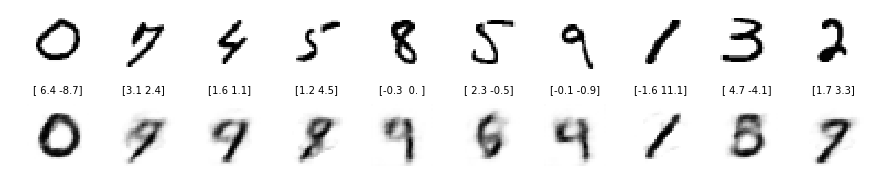

In [26]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = AE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


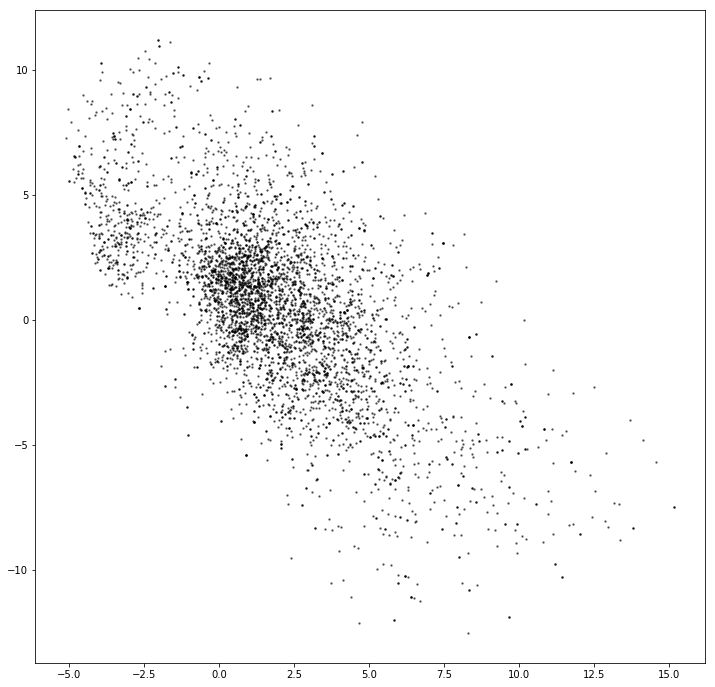

In [27]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

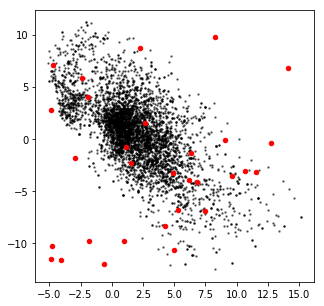

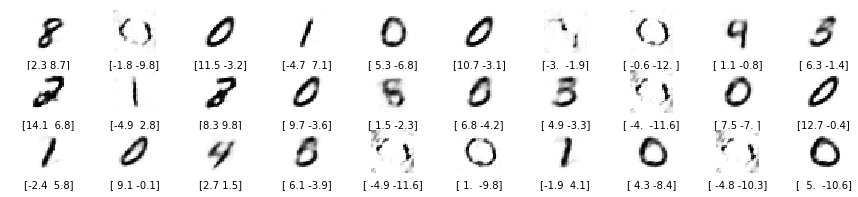

In [28]:
figsize = 5

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

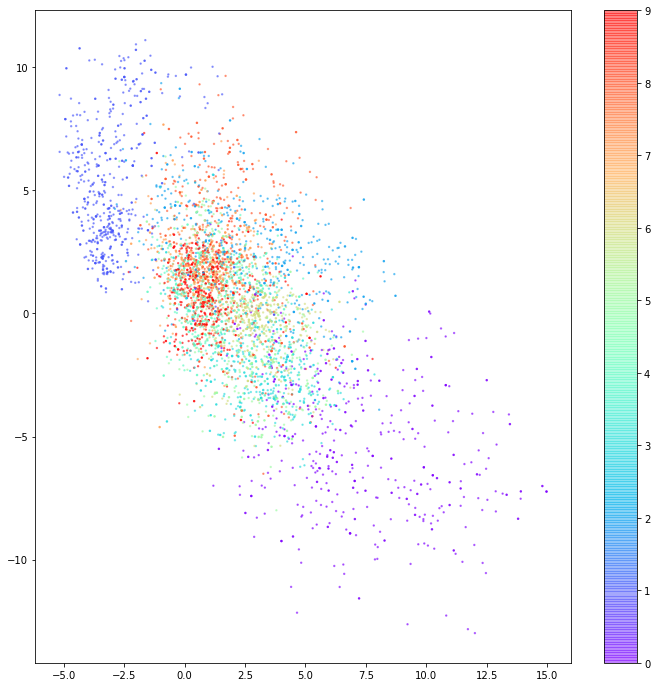

In [29]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

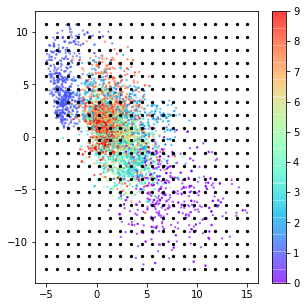

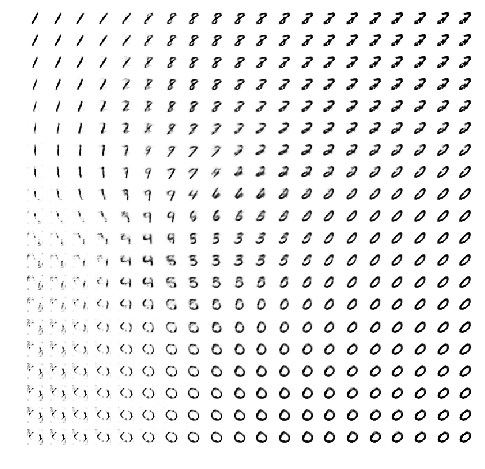

In [30]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

## torch 读取MNIST数据集

9920512it [00:00, 92875972.71it/s]                             

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



32768it [00:00, 1022238.57it/s]
1654784it [00:00, 29532240.45it/s]
8192it [00:00, 339969.90it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


Done!


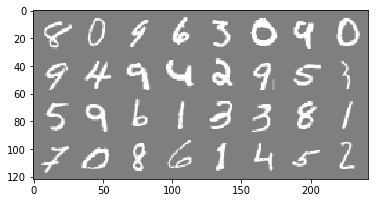

In [1]:
import torch
from torch import nn
from torchvision import datasets,transforms
import torchvision
import matplotlib.pyplot as plt
import cv2

transform=transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize([0.5],[0.5])
])

train_dataset=datasets.MNIST(root='./data',train=True,transform=transform,download=True)
test_dataset=datasets.MNIST(root='./data',train=False,transform=transform,download=True)

batch_size=32
train_dataloader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

images,labels=next(iter(train_dataloader))

#拼接多张图片
img=torchvision.utils.make_grid(images,nrow=8,padding=2)
img=img.numpy().transpose(1, 2, 0)
#(h,w,c)变(c,h,w)

std=[0.5,0.5,0.5]
mean=[0.5,0.5,0.5]
img=img*std+mean

plt.imshow(img)
plt.show()

img =img.transpose((2,0,1))
torchvision.utils.save_image(torch.from_numpy(img).unsqueeze(0),'./data/1.png')

## keras 读取MNIST

fig.add_subplot 接收三个参数，分别表示所需的行数、列数和子图位置

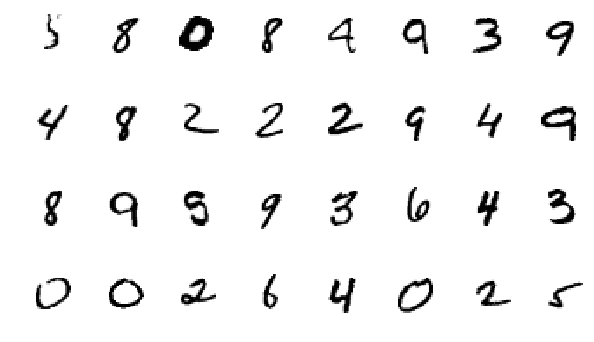

In [59]:
from keras.datasets import mnist
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = load_mnist()

n_to_show = 32
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(hspace=0.3, wspace=0.5)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(4,8, i+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')
    
fig.savefig('1.png')

## pytorch实现AE架构

In [2]:
class Reshape(nn.Module):
    def __init__(self, args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)
class AutoEncoder(nn.Module):
    def __init__(self,):
        super(AutoEncoder,self).__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=7),
            nn.Flatten(),
            nn.Linear(in_features=64,out_features=2),
        )
        
        self.decoder=nn.Sequential(
            nn.Linear(2,64),
            Reshape((-1, 64, 1, 1)),
            nn.ConvTranspose2d(64,32,kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.Sigmoid(),
        
        )
        
    def forward(self,x):
        return self.decoder(self.encoder(x))
    
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=AutoEncoder().to(device)

In [85]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [99]:

from torchsummary import summary

summary(model, input_size=(1,28,28), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           4,640
              ReLU-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 1, 1]         100,416
           Flatten-6                   [-1, 64]               0
            Linear-7                    [-1, 2]             130
            Linear-8                   [-1, 64]             192
           Reshape-9             [-1, 64, 1, 1]               0
  ConvTranspose2d-10             [-1, 32, 7, 7]         100,384
             ReLU-11             [-1, 32, 7, 7]               0
  ConvTranspose2d-12           [-1, 16, 14, 14]           4,624
             ReLU-13           [-1, 16, 14, 14]               0
  ConvTranspose2d-14            [-1, 1,

In [3]:
import torch.optim as optim

learning_rate=1e-3
num_epochs=10

criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)


## 自定义loss，需要实现foward函数

In [4]:

class RMSE_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        return torch.mean(torch.pow((x - y), 2))
criterion=RMSE_loss()

In [5]:
import tqdm
for epoch in range(num_epochs):
    for data,label in tqdm.tqdm(train_dataloader):
        data=data.to(device)
        output=model(data)
        
        loss=criterion(data,output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch[{}/{}], loss:{:.4f}".format(epoch+1, num_epochs, loss.data))
        
        

  0%|          | 3/1875 [00:00<01:13, 25.59it/s]

Epoch[1/10], loss:0.0502


  0%|          | 3/1875 [00:00<01:03, 29.65it/s]

Epoch[2/10], loss:0.0502


  0%|          | 3/1875 [00:00<01:05, 28.74it/s]

Epoch[3/10], loss:0.0501


  0%|          | 3/1875 [00:00<01:04, 29.22it/s]

Epoch[4/10], loss:0.0439


  0%|          | 3/1875 [00:00<01:06, 28.11it/s]

Epoch[5/10], loss:0.0424


  0%|          | 3/1875 [00:00<01:07, 27.60it/s]

Epoch[6/10], loss:0.0410


  0%|          | 3/1875 [00:00<01:18, 23.99it/s]

Epoch[7/10], loss:0.0387


  0%|          | 3/1875 [00:00<01:04, 28.95it/s]

Epoch[8/10], loss:0.0449


  0%|          | 3/1875 [00:00<01:04, 29.05it/s]

Epoch[9/10], loss:0.0492


100%|██████████| 1875/1875 [01:02<00:00, 30.09it/s]

Epoch[10/10], loss:0.0402


In [6]:
save_path='./AE.pth'
torch.save(model.state_dict(),save_path)

In [7]:
load_pth='./AE.pth'
load_weights=torch.load(load_pth)
AE=AutoEncoder()
AE.load_state_dict(load_weights)
#AE.to(device)

<All keys matched successfully>

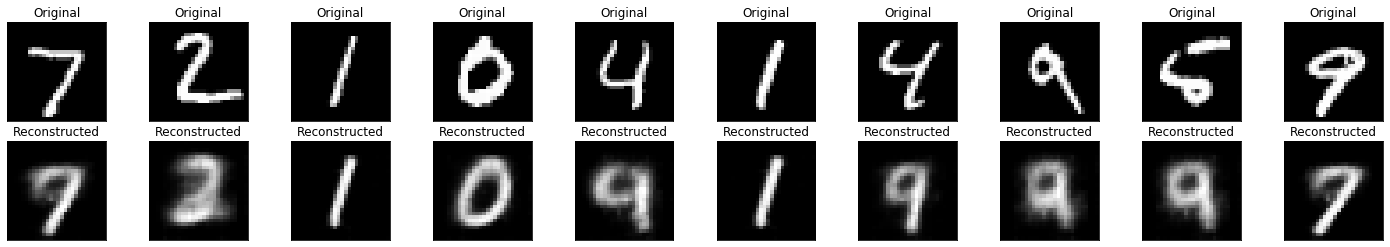

In [8]:
# 迭代测试数据集，生成迭代器
dataiter = iter(test_dataloader)

# 从迭代器中获取下一个批次的图像和标签
images, labels = next(dataiter)

# 使用模型进行推断，处理获取的图像数据，并将结果保存在output变量中
output = AE(images.to(device))

# 创建子图和轴对象，其中第一行显示原始图像，第二行显示重构后的图像
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# 循环遍历前10个图像，绘制原始图像和重构图像并添加标题
for i in range(10):
    # 显示原始图像
    axes[0,i].imshow(images[i].squeeze().numpy(), cmap='gray')
    axes[0,i].set_title("Original")
    axes[0,i].get_xaxis().set_visible(False)
    axes[0,i].get_yaxis().set_visible(False)

    # 显示重构后的图像
    axes[1,i].imshow(output[i].squeeze().cpu().detach().numpy(), cmap='gray')
    axes[1,i].set_title("Reconstructed")
    axes[1,i].get_xaxis().set_visible(False)
    axes[1,i].get_yaxis().set_visible(False)

# 显示生成的子图
plt.show()


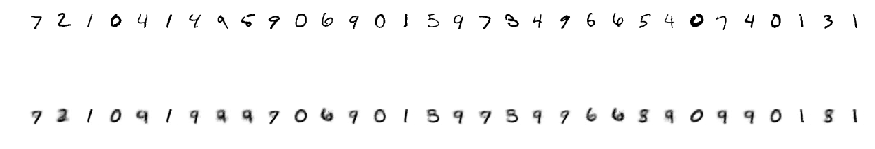

In [9]:
import numpy as np
n_to_show = 32


example_images,_= next(iter(test_dataloader))
example_images=example_images.to(device)
AE.to(device)
z_points = AE.encoder(example_images)

reconst_images = AE.decoder(z_points)
z_points=z_points.cpu().detach().numpy()
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
   # ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img.cpu().detach().numpy(), cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img.cpu().detach().numpy(), cmap='gray_r')


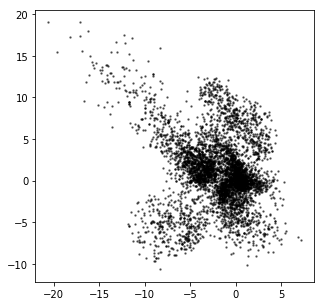

In [23]:
n_to_show = 5000
grid_size = 15
figsize = 5
from torch.utils.data import WeightedRandomSampler,DataLoader

dataloader = DataLoader(dataset=train_dataset,
                    batch_size=n_to_show,  # 组织成batch大小
                    sampler=WeightedRandomSampler(torch.ones(len(train_dataset)),n_to_show))
example_batch,label=next(iter(dataloader))
example_images = example_batch.to(device)
z_points = AE.encoder(example_images)
z_points=z_points.cpu().detach().numpy()
min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

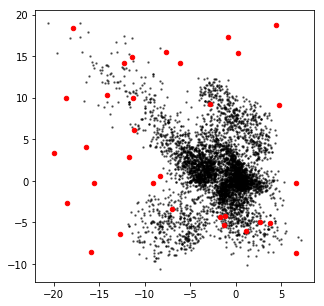

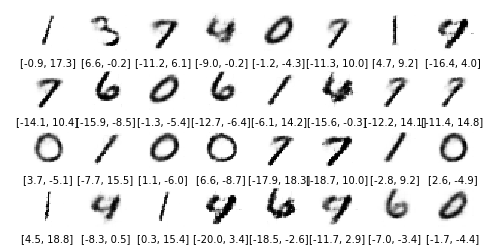

In [42]:
figsize = 5

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 8
grid_depth = 4
figsize = 8

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)

z_grid = torch.Tensor(list(zip(x, y)))
plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()
z_grid = z_grid.unsqueeze(0).reshape(grid_size * grid_depth,1,2).to(device)
reconst = AE.decoder(z_grid)


fig = plt.figure(figsize=(grid_size, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    img=reconst[i].squeeze()
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(list(np.round(z_grid[i].squeeze().numpy(),1))), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(img.detach().numpy(), cmap = 'Greys')

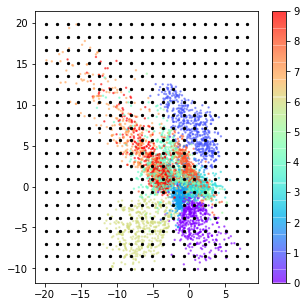

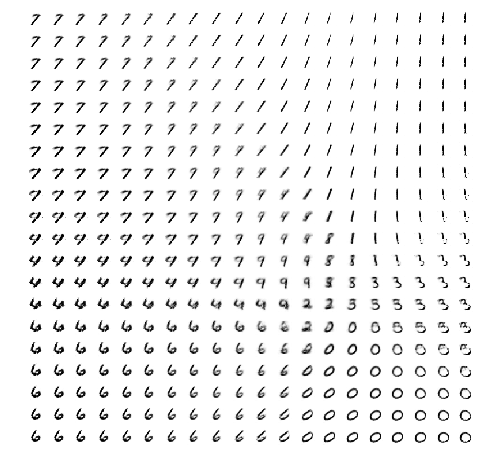

In [53]:
n_to_show = 5000
grid_size = 20
figsize = 8

dataloader = DataLoader(dataset=train_dataset,
                    batch_size=n_to_show,  # 组织成batch大小
                    sampler=WeightedRandomSampler(torch.ones(len(train_dataset)),n_to_show))
example_batch,example_labels=next(iter(dataloader))
example_images = example_batch.to(device)

#example_idx = np.random.choice(range(len(x_test)), n_to_show)
#example_images = x_test[example_idx]
#example_labels = y_test[example_idx]

z_points = AE.encoder(example_images).detach().cpu().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()

z_grid = np.array(list(zip(xv, yv)))
z_grid = torch.from_numpy(z_grid).float()#.unsqueeze(0).reshape(grid_size * grid_depth,1,2).to(device)
reconst = AE.decoder(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    img=reconst[i].squeeze()
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(img.detach().cpu().numpy(), cmap = 'Greys')